Test Jacobi-iterator for thermal problems using MFEANet

* Single phase material - early termination

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.nn.modules.utils import _pair

import matplotlib.pyplot as plt
import math
import time

from utils import plot
from feanet.singlegrid import SingleGrid
from feanet.multigrid import MultiGrid
from data.dataset import MechanicalDataSet


Create plots for convergence test

In [2]:
device_predict = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #torch.device('cpu') #
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
N = [2**1+1, 2**2+1, 2**3+1, 2**4+1, 2**5+1, 2**6+1, 2**7+1, 2**8+1, 2**9+1]
q_v11 = [0.11111110105447959, 0.20320289267157887, 0.22705374241213908, 0.23623111562228755, 
         0.2521629576411248, 0.25900978515692, 0.26230444531364716, 0.26295500430251095, 0.26316125814795244]
q_jac = [0.33333329777930615, 0.7357023129437866, 0.9258110664371474, 0.9809080721911905, 0.9809080721911905, 
         0.9987957479351752, 0.9996457255615815, 0.9996247757202597, 0.9996247757202597]

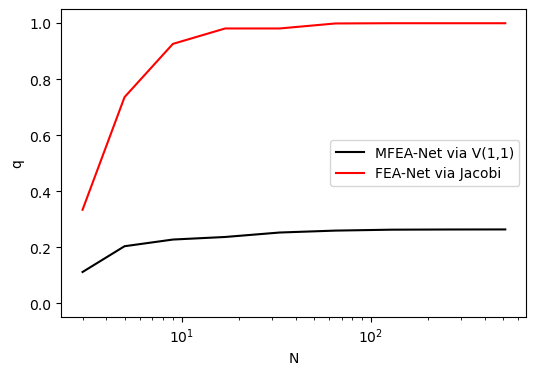

In [4]:
plt.figure(figsize=(6, 4))
plt.plot(N, q_v11, label='MFEA-Net via V(1,1)', c='k')
plt.plot(N, q_jac, label='FEA-Net via Jacobi', c='r')
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('N')
plt.ylabel('q')
plt.legend(loc='center right')
plt.ylim([-0.05, 1.05])
plt.savefig('results/q_compare.png', dpi=500, bbox_inches='tight')

In [5]:
bs = 1 # batch size
k = 0 # test data index
ku, kf = 1, 1
no_neumann = True
n_elem = 2**8
h = 2.0/n_elem
test_set = MechanicalDataSet('data/data_thermal/dirich_plate_zero_257x257.h5', device)
test_dataloader = DataLoader(test_set, batch_size=bs, shuffle=True)
elem_mask_test, node_mask_test, dirich_idx_test, dirich_value_test, neumann_idx_test, neumann_value_test, neumann_conn_test, material_test, f_test, u_test = next(iter(test_dataloader))

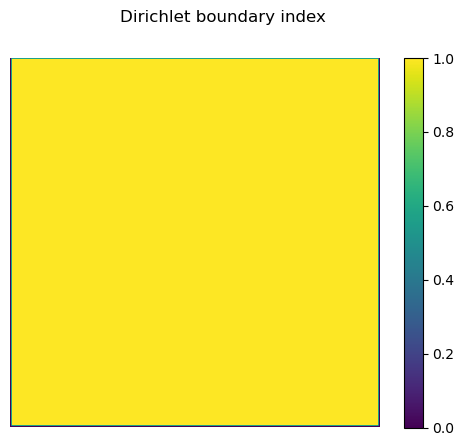

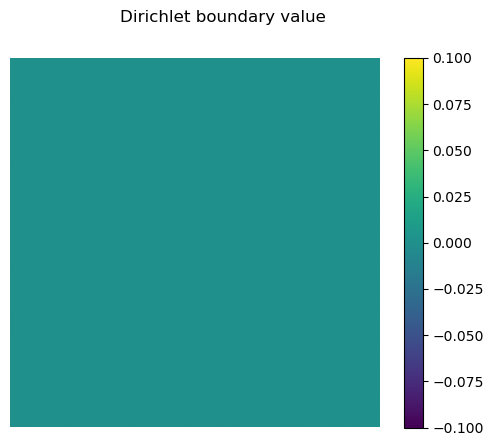

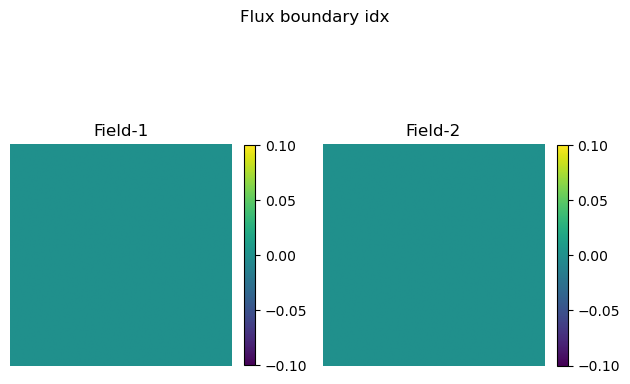

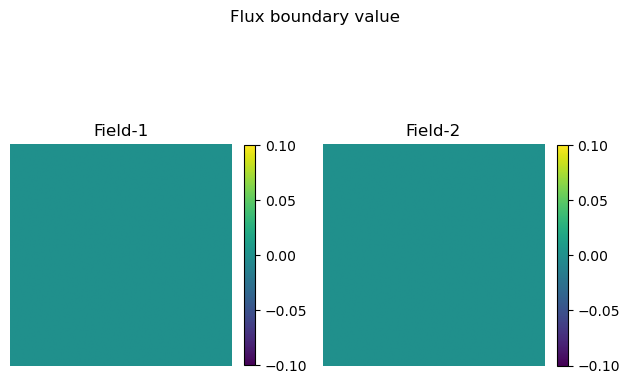

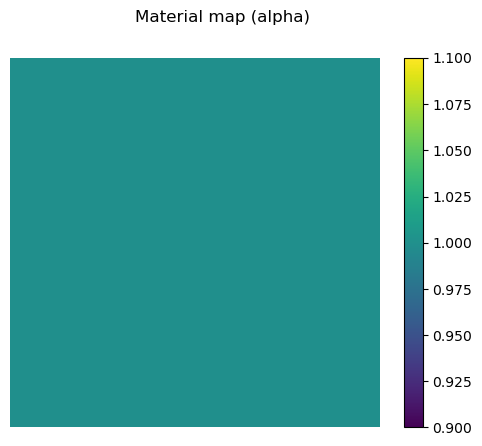

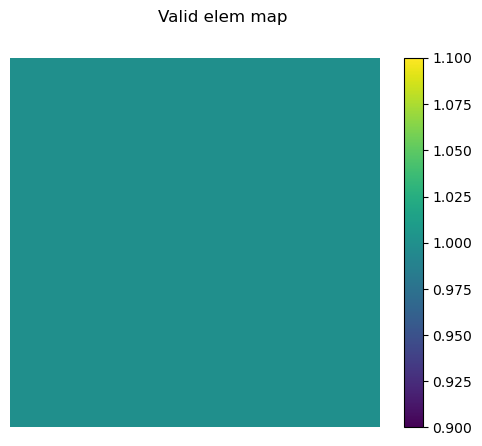

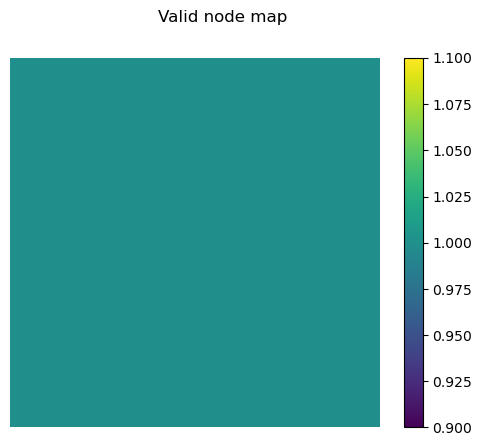

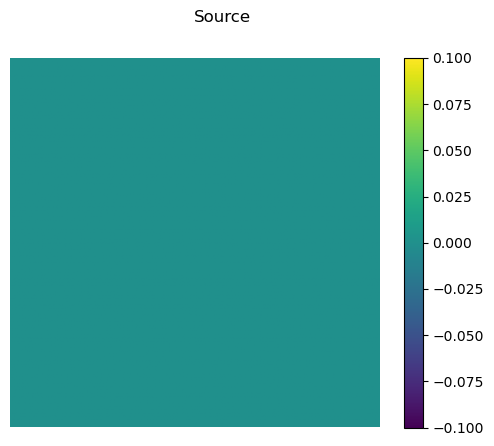

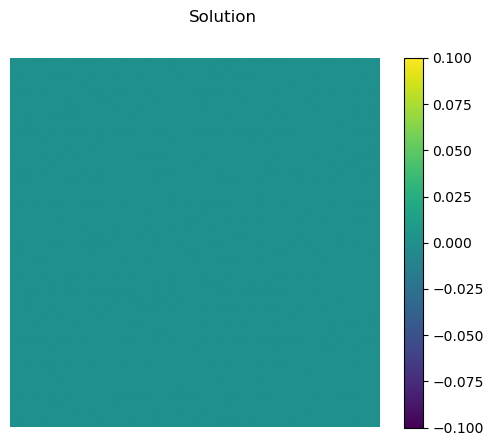

In [6]:
plot.plot_thermalfield(dirich_idx_test[k], ftitle='Dirichlet boundary index')
plot.plot_thermalfield(dirich_value_test[k], ftitle='Dirichlet boundary value')
plot.plot_elasticfield(neumann_idx_test[k], ftitle='Flux boundary idx')
plot.plot_elasticfield(neumann_value_test[k], ftitle='Flux boundary value')
plot.plot_thermalfield(material_test[k], ftitle='Material map (alpha)')
plot.plot_thermalfield(elem_mask_test[k], ftitle='Valid elem map')
plot.plot_thermalfield(node_mask_test[k], ftitle='Valid node map')
plot.plot_thermalfield(f_test[k], ftitle='Source')
plot.plot_thermalfield(u_test[k], ftitle='Solution')

In [7]:
solution_test, rhs_test, d_test, d_idx_test, t_idx_test, t_test, t_conn_test, m_test, emsk_test, nmsk_test = (torch.unsqueeze(u_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(f_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(dirich_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_idx_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_value_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(neumann_conn_test[k], 0).to(device_predict), 
                                                                         torch.unsqueeze(material_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(elem_mask_test[k], 0).to(device_predict),
                                                                         torch.unsqueeze(node_mask_test[k], 0).to(device_predict))

## Test multigrid performance

In [8]:
EPS = 1e-6
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term8 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term8.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')


0 31.986108095720414
1 7.123398982471331
2 1.741526510970414
3 0.43017313379360833
4 0.10703054610506524
5 0.02679648995565935
6 0.006746032533300396
7 0.0017068026055334351
8 0.0004338013005230926
9 0.0001107157655877643
10 2.8366028629204397e-05
11 7.293443176586892e-06
12 1.8814712055619203e-06
13 4.868422841709166e-07
Solution converges after 13 Jacobi multigrid iterations in 0.2189183235168457 seconds.


In [9]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=7, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term7 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term7.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 7.123444034269407
2 1.741574261043935
3 0.4302165564260923
4 0.10706839356828951
5 0.026828863734974246
6 0.006773419181314764
7 0.0017297457445175344
8 0.00045273428263255223
9 0.00012582342012989976
10 3.956782810027958e-05
11 1.467223769542992e-05
12 6.169770160980533e-06
13 2.755438702474912e-06
14 1.2581945208136083e-06
15 5.787633656321423e-07
Solution converges after 15 Jacobi multigrid iterations in 0.22920489311218262 seconds.


In [10]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=6, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term6 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term6.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 7.123672366721284
2 1.7421280578702976
3 0.4315942917354581
4 0.11061778498421826
5 0.035097959700533
6 0.019664324175123152
7 0.015164819984730762
8 0.01230376579725043
9 0.010035102041039122
10 0.008189022197012386
11 0.006682905907796261
12 0.00545382406588099
13 0.004450790953952616
14 0.003632229744069348
15 0.002964213161166171
16 0.002419053945247497
17 0.0019741569434852937
18 0.0016110825663108949
19 0.0013147825172372945
20 0.0010729760868863716
21 0.0008756411558106252
22 0.0007145988089771085
23 0.0005831743453388381
24 0.0004759206323730822
25 0.0003883923394928902
26 0.0003169616930129291
27 0.0002586681162888023
28 0.0002110955230847725
29 0.00017227217836417917
30 0.00014058897604579584
31 0.00011473274659488803
32 9.363183025757386e-05
33 7.641166011947788e-05
34 6.235851404541764e-05
35 5.088993313157032e-05
36 4.153058060763505e-05
37 3.389254061600076e-05
38 2.7659240314019058e-05
39 2.257232892087877e-05
40 1.842096988665613e-05
41 1.50331023

In [11]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=5, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term5 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term5.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 7.125391700209511
2 1.7461123143810164
3 0.4407040356099094
4 0.13184071827130422
5 0.07022060508765696
6 0.056976495192773424
7 0.05053270874338978
8 0.04588733983573216
9 0.04223773749276208
10 0.03925318770545513
11 0.0367303380378362
12 0.034535672184679164
13 0.032580798561482556
14 0.030807045791576275
15 0.029175253593051124
16 0.02765900011728537
17 0.02624014797305068
18 0.02490594093147241
19 0.0236471245164145
20 0.022456735178178828
21 0.02132932237572234
22 0.020260449289857718
23 0.019246372141245697
24 0.018283833697484753
25 0.017369929678006678
26 0.016502021670885037
27 0.01567767973495268
28 0.014894643970492557
29 0.014150798238041976
30 0.01344415168575659
31 0.012772825323934351
32 0.012135041888563666
33 0.01152911787334906
34 0.010953457014792901
35 0.010406544772361326
36 0.00988694350939113
37 0.00939328818445498
38 0.008924282429127718
39 0.008478694930294468
40 0.008055356062086487
41 0.007653154729774799
42 0.00727103539904212
43 0.00

In [12]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=4, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term4 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term4.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 7.138667653041386
2 1.7775728557999628
3 0.5084113320766298
4 0.24288504473924202
5 0.18568578173365669
6 0.15999118598074583
7 0.1421679220861337
8 0.1284614267487916
9 0.11749912657902407
10 0.10850056451253097
11 0.1009631520096552
12 0.09454534242144472
13 0.08900620549031477
14 0.08417064676522983
15 0.07990823664905097
16 0.07611976598823332
17 0.07272839827998244
18 0.06967366576982786
19 0.06690728734528166
20 0.0643901906727045
21 0.06209035302353045
22 0.05998121248526707
23 0.05804048487004425
24 0.056249274080618694
25 0.05459139756552762
26 0.0530528710104627
27 0.05162151179491566
28 0.05028663151469574
29 0.049038795574775654
30 0.04786963346122904
31 0.04677168743088955
32 0.045738290428542425
33 0.04476346633867024
34 0.043841847402457335
35 0.04296860492525271
36 0.04213939037117729
37 0.04135028466910578
38 0.04059775409750884
39 0.03987861151985126
40 0.039189982041850785
41 0.03852927238311681
42 0.037894143418509336
43 0.03728248546409164
44

In [13]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=3, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term3 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term3.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 7.242588934369988
2 2.012021646160607
3 0.8814726976787972
4 0.6290680775853089
5 0.5235172728431783
6 0.45513350604198716
7 0.4048665721682626
8 0.3659500213001423
9 0.33478978085692107
10 0.3091989562701847
11 0.2877558303336569
12 0.2694923275442949
13 0.253724729006934
14 0.23995544008026237
15 0.22781309929664348
16 0.21701455613161696
17 0.20733989532955222
18 0.19861554493911418
19 0.19070255855880378
20 0.1834883044272893
21 0.17688045405434408
22 0.17080255749342976
23 0.16519073505988227
24 0.1599911686057639
25 0.155158174594866
26 0.1506527066894218
27 0.14644117962985
28 0.14249453637508985
29 0.1387875014790551
30 0.13529797851440373
31 0.13200655997353822
32 0.12889612577241455
33 0.12595151212473826
34 0.1231592367350835
35 0.12050726938899989
36 0.11798483938260677
37 0.11558227303632006
38 0.11329085592230217
39 0.11110271550774942
40 0.10901072075284189
41 0.10700839585942325
42 0.10508984588609864
43 0.10324969235881735
44 0.10148301733681604


In [14]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=2, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term2 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term2.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 8.032930958284314
2 3.365538381996238
3 2.252990564400487
4 1.7935992108699421
5 1.5153827796694421
6 1.3217717069358776
7 1.1777035670149694
8 1.0657056348239202
9 0.9758011138866661
10 0.9018251604948881
11 0.8397458750291479
12 0.7868071936495578
13 0.7410567921295652
14 0.7010703786569894
15 0.6657828489772508
16 0.634380716369189
17 0.6062312463393051
18 0.5808344098915436
19 0.557789483706051
20 0.5367713175955735
21 0.5175131408678474
22 0.49979388874220704
23 0.48342871451491526
24 0.46826178656575773
25 0.4541607501146041
26 0.44101241942714137
27 0.42871939143788185
28 0.41719735768929295
29 0.4063729513695475
30 0.396182008572049
31 0.3865681532396471
32 0.3774816372670529
33 0.3688783833870306
34 0.36071919044621187
35 0.3529690696508892
36 0.3455966871491253
37 0.33857389349135353
38 0.3318753244920391
39 0.3254780610996489
40 0.3193613382899919
41 0.3135062948905891
42 0.3078957577409409
43 0.3025140547852437
44 0.29734685264829025
45 0.292381015013

In [15]:
with torch.no_grad():
    n = n_elem
    n_mg_jac = 0
    mg_jac = MultiGrid(h, n, no_neumann, pacnet=None, device=device, L=1, nb_layers=3, iterator='jac') # create a multigrid model
    mg_jac.ProblemDictArray(rhs_test,t_test,t_conn_test,d_test,d_idx_test,m_test,nmsk_test)
    u_mg_jac = torch.ones((1, 1, n+1, n+1), requires_grad=False, dtype=torch.double).to(device)
    u_mg_jac = mg_jac.iterators[0].grid.jac.reset_boundary(u_mg_jac, d_test, d_idx_test)
    residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test,nmsk_test)
    res = torch.norm(residual).item()
    err_occured = False
    res_arr_term1 = [res]
    print(n_mg_jac, res)

    start = time.time()
    while (abs(res) > EPS):
        u_mg_jac = mg_jac.Step(u_mg_jac)
        residual = mg_jac.iterators[0].grid.net(None, None, h, u_mg_jac, d_idx_test, rhs_test, t_test, t_conn_test, m_test, nmsk_test)
        res = torch.norm(residual).item()
        res_arr_term1.append(res)
        n_mg_jac += 1
        print(n_mg_jac, res)

        if(res == torch.inf or math.isnan(res)):
            err_occured = True
            break

    end = time.time()

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg_jac, "Jacobi multigrid iterations in", end-start, 'seconds.')

0 31.986108095720414
1 12.961535966429809
2 8.716031187443319
3 6.733735661879714
4 5.55965951867511
5 4.77347208386266
6 4.205673318353358
7 3.7739552621640935
8 3.433225414350587
9 3.1565807837802744
10 2.9269146923315645
11 2.732797490996156
12 2.5662838488735207
13 2.4216682926687487
14 2.2947412231406212
15 2.1823245533237596
16 2.081971155889041
17 1.9917642003069516
18 1.9101795342419106
19 1.8359890604369418
20 1.7681914783200519
21 1.7059617191231722
22 1.6486134167550697
23 1.5955706384365052
24 1.5463463032929177
25 1.500525504832039
26 1.4577524789019551
27 1.4177203159232619
28 1.3801627629529498
29 1.3448476342181617
30 1.3115714718614397
31 1.2801551873309949
32 1.2504404785206835
33 1.2222868654410284
34 1.1955692227218537
35 1.1701757139603208
36 1.1460060532051906
37 1.1229700343875197
38 1.1009862814840337
39 1.0799811815076346
40 1.0598879697082066
41 1.0406459421114966
42 1.0221997750794165
43 1.0044989352116827
44 0.9874971658255581
45 0.971152038605242
46 0.95542

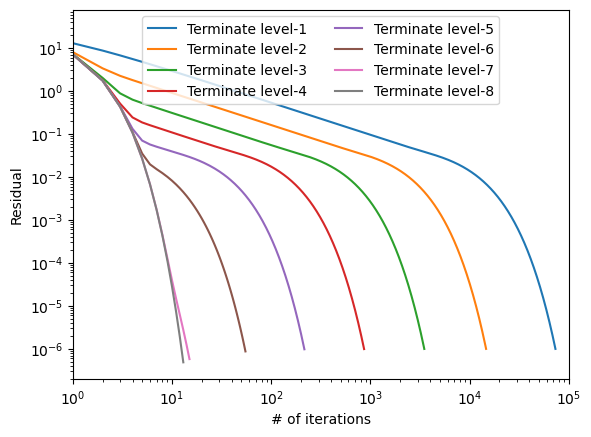

In [20]:
plt.plot(res_arr_term1, label='Terminate level-1')
plt.plot(res_arr_term2, label='Terminate level-2')
plt.plot(res_arr_term3, label='Terminate level-3')
plt.plot(res_arr_term4, label='Terminate level-4')
plt.plot(res_arr_term5, label='Terminate level-5')
plt.plot(res_arr_term6, label='Terminate level-6')
plt.plot(res_arr_term7, label='Terminate level-7')
plt.plot(res_arr_term8, label='Terminate level-8')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('# of iterations')
plt.ylabel('Residual')
plt.xlim([1,1e5])
plt.legend(loc='upper center', ncol=2)
plt.savefig('results/early_term.jpg', dpi=500, bbox_inches='tight')
plt.show()

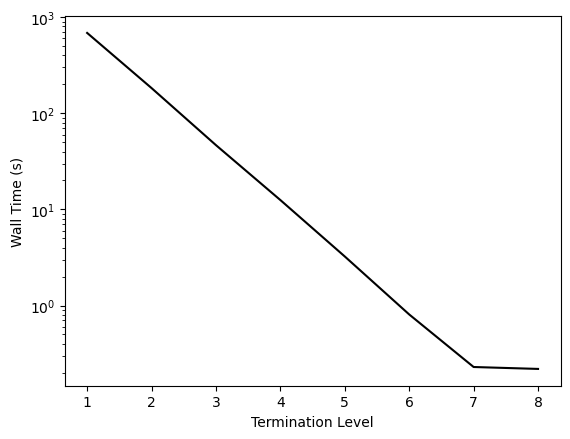

In [24]:
N = [8, 7, 6, 5, 4, 3, 2, 1]
wall_time = [0.2189183235168457, 0.22920489311218262, 0.8068540096282959, 3.235522747039795, 12.501515865325928, 46.572997093200684, 182.74805808067322, 685.0513660907745]
plt.plot(N, wall_time, c='k')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('Termination Level')
plt.ylabel('Wall Time (s)')
#plt.legend(loc='center right')
#plt.ylim([-0.05, 1.05])
plt.savefig('results/early_term_time.png', dpi=500, bbox_inches='tight')